**IMPORTS**

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import joblib
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.tree import export_text, plot_tree
import joblib
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.tree import _tree
import shap

from sklearn.base import BaseEstimator, TransformerMixin


In [162]:
# Load the data
df = pd.read_csv('./data/train_data.csv')
df.head(2)

,offer expiration,income_range,no_visited_Cold drinks,travelled_more_than_15mins_for_offer,Restaur_spend_less_than20,Marital Status,restaurant type,age,Prefer western over chinese,travelled_more_than_25mins_for_offer,...,restuarant_opposite_direction_house,has Children,visit restaurant with rating (avg),temperature,Restaur_spend_greater_than20,Travel Time,Climate,drop location,Prefer home food,Offer Accepted
0,2days,₹100000 or More,4~8,1,less1,Married partner,4 star restaurant,36,0,0,...,0,0,4,67,less1,22,Spring,Location B,0,No
1,2days,₹87500 - ₹99999,4~8,0,4~8,Married partner,Take-away restaurant,50plus,0,0,...,0,1,3,89,1~3,18,Summer,Location B,0,Yes


**EDA**

- Summary Statistics

In [163]:
data = df.copy()

# Getting the summary statistics of the dataset
summary_statistics = data.describe(include='all')

# Displaying the summary statistics
summary_statistics.head()


,offer expiration,income_range,no_visited_Cold drinks,travelled_more_than_15mins_for_offer,Restaur_spend_less_than20,Marital Status,restaurant type,age,Prefer western over chinese,travelled_more_than_25mins_for_offer,...,restuarant_opposite_direction_house,has Children,visit restaurant with rating (avg),temperature,Restaur_spend_greater_than20,Travel Time,Climate,drop location,Prefer home food,Offer Accepted
count,12379,12379,12181,12379.000000,12258,12379,12379,12379,12379.000000,12379.000000,...,12379.000000,12379.000000,12379.000000,12379.000000,12219,12379.000000,12379,12379,12379.000000,12379
unique,2,9,5,NaN,5,5,5,8,NaN,NaN,...,NaN,NaN,NaN,NaN,5,NaN,3,3,NaN,2
top,2days,₹25000 - ₹37499,less1,NaN,1~3,Married partner,Cold drinks,21,NaN,NaN,...,NaN,NaN,NaN,NaN,less1,NaN,Summer,Location A,NaN,Yes
freq,6791,2010,3304,NaN,5248,4987,3471,2602,NaN,NaN,...,NaN,NaN,NaN,NaN,5992,NaN,8065,5590,NaN,6994
mean,NaN,NaN,NaN,0.565393,NaN,NaN,NaN,NaN,0.506665,0.119396,...,0.787382,0.415623,1.987802,71.139187,NaN,13.947896,NaN,NaN,0.509815,NaN


- handling missing values

In [164]:
# Identifying the columns with missing values and calculating the percentage of missing data
missing_data = data.isnull().sum()
missing_percentage = (missing_data / len(data)) * 100

# Combining the missing data count and percentage into a DataFrame
missing_info = pd.DataFrame({"Missing Values": missing_data, "Percentage": missing_percentage})

# Formatting the missing percentage with two decimal places followed by a percentage symbol
missing_info['Percentage'] = missing_info['Percentage'].apply(lambda x: f"{x:.2f} %")

# Filtering only the columns with missing values
missing_info = missing_info[missing_info["Missing Values"] > 0]

# Displaying the missing information
missing_info


,Missing Values,Percentage
no_visited_Cold drinks,198,1.60 %
Restaur_spend_less_than20,121,0.98 %
no_visited_bars,93,0.75 %
car,12268,99.10 %
no_Take-aways,144,1.16 %
Restaur_spend_greater_than20,160,1.29 %


In [165]:
# Imputing missing values using the mode for the identified categorical columns
columns_to_impute = ['no_visited_Cold drinks', 'Restaur_spend_less_than20', 
                     'no_visited_bars', 'no_Take-aways', 'Restaur_spend_greater_than20']

for column in columns_to_impute:
    mode_value = data[column].mode()[0]
    data[column].fillna(mode_value, inplace=True)

# Removing the 'car' column as it has a high percentage of missing values
data.drop(columns=['car'], inplace=True)

# Checking if the missing values are handled
missing_after_imputation = data.isnull().sum().sum()
missing_after_imputation


0

- Summary Statistics of Cleaned data (Revisited)

In [166]:
# Getting the summary statistics of the cleaned dataset
summary_statistics_cleaned = data.describe(include='all')

# Displaying the summary statistics
summary_statistics_cleaned.head()


,offer expiration,income_range,no_visited_Cold drinks,travelled_more_than_15mins_for_offer,Restaur_spend_less_than20,Marital Status,restaurant type,age,Prefer western over chinese,travelled_more_than_25mins_for_offer,...,restuarant_opposite_direction_house,has Children,visit restaurant with rating (avg),temperature,Restaur_spend_greater_than20,Travel Time,Climate,drop location,Prefer home food,Offer Accepted
count,12379,12379,12379,12379.000000,12379,12379,12379,12379,12379.000000,12379.000000,...,12379.000000,12379.000000,12379.000000,12379.000000,12379,12379.000000,12379,12379,12379.000000,12379
unique,2,9,5,NaN,5,5,5,8,NaN,NaN,...,NaN,NaN,NaN,NaN,5,NaN,3,3,NaN,2
top,2days,₹25000 - ₹37499,less1,NaN,1~3,Married partner,Cold drinks,21,NaN,NaN,...,NaN,NaN,NaN,NaN,less1,NaN,Summer,Location A,NaN,Yes
freq,6791,2010,3502,NaN,5369,4987,3471,2602,NaN,NaN,...,NaN,NaN,NaN,NaN,6152,NaN,8065,5590,NaN,6994
mean,NaN,NaN,NaN,0.565393,NaN,NaN,NaN,NaN,0.506665,0.119396,...,0.787382,0.415623,1.987802,71.139187,NaN,13.947896,NaN,NaN,0.509815,NaN


- Univariate Analysis

Analyzing Single Variables through Histograms, Box Plots, etc.
(Numerical Variables)

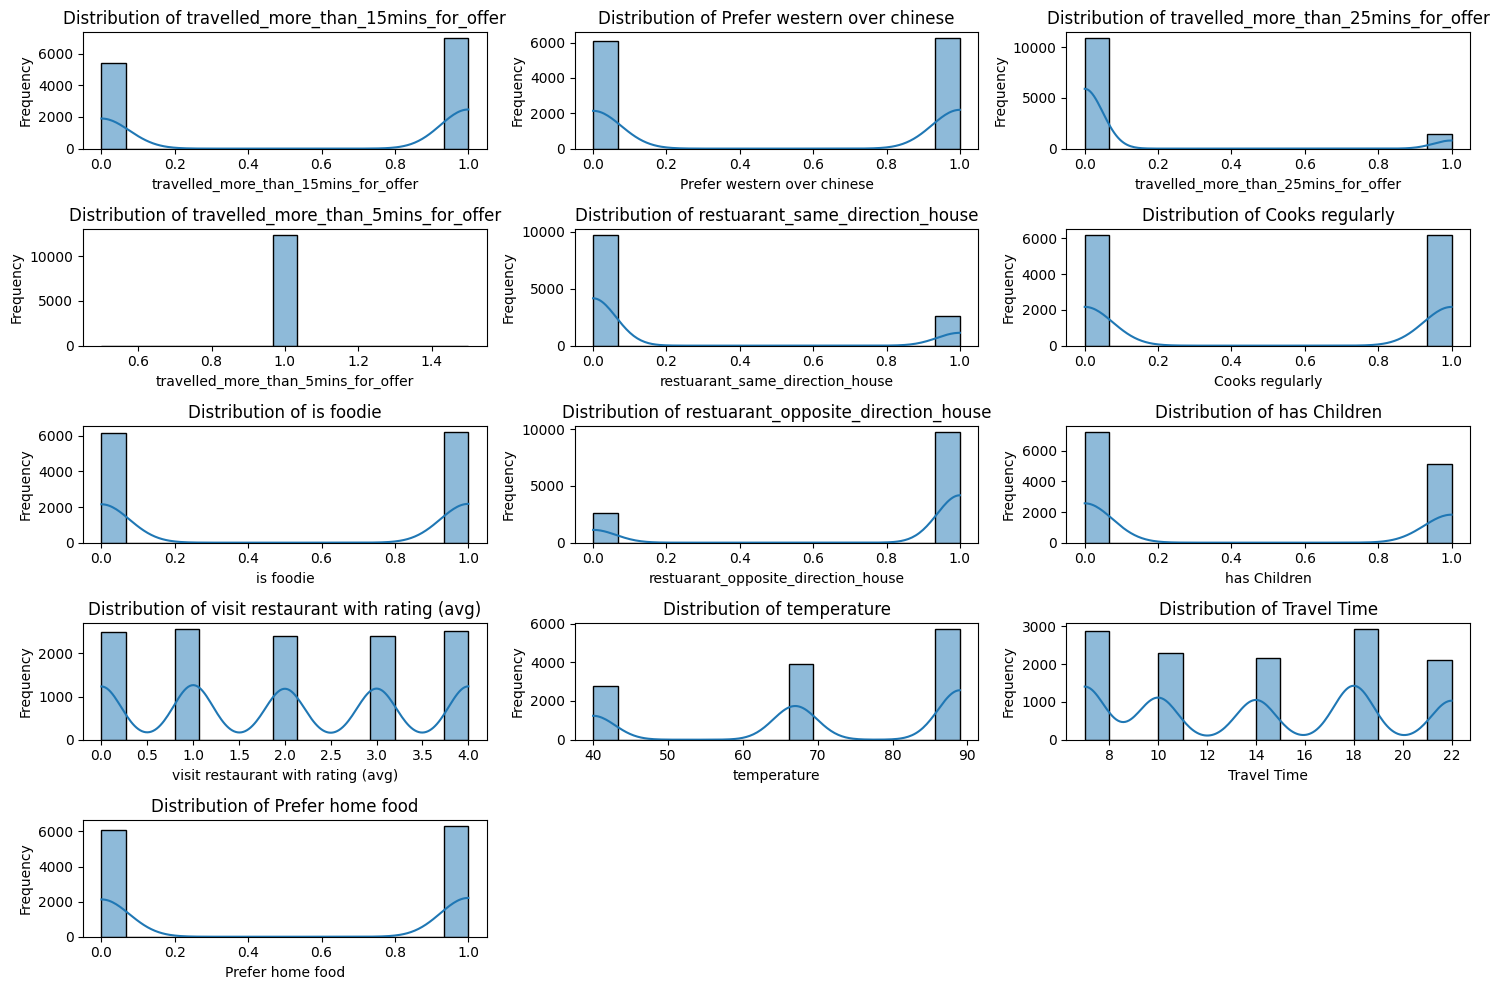

In [167]:
# Determining the number of rows and columns for the subplots
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns

num_numerical_columns = len(numerical_columns)
num_rows = (num_numerical_columns // 3) + (1 if num_numerical_columns % 3 != 0 else 0)

# Plotting histograms for numerical variables
plt.figure(figsize=(15, 10))
for idx, col in enumerate(numerical_columns, 1):
    plt.subplot(num_rows, 3, idx)
    sns.histplot(data[col], bins=15, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [168]:
data["travelled_more_than_5mins_for_offer"].unique()

array([1], dtype=int64)

- Column `travelled_more_than_5mins_for_offer` is unnecessary, so remove it

In [169]:
print("before dropping column", len(data.columns))
data.drop(columns=["travelled_more_than_5mins_for_offer"], inplace=True)
print("after dropping column", len(data.columns))

before dropping column 30
after dropping column 29


- Bivariate Analysis

Analyzing the Relationship Between Two Variables

(Scatter Plots)

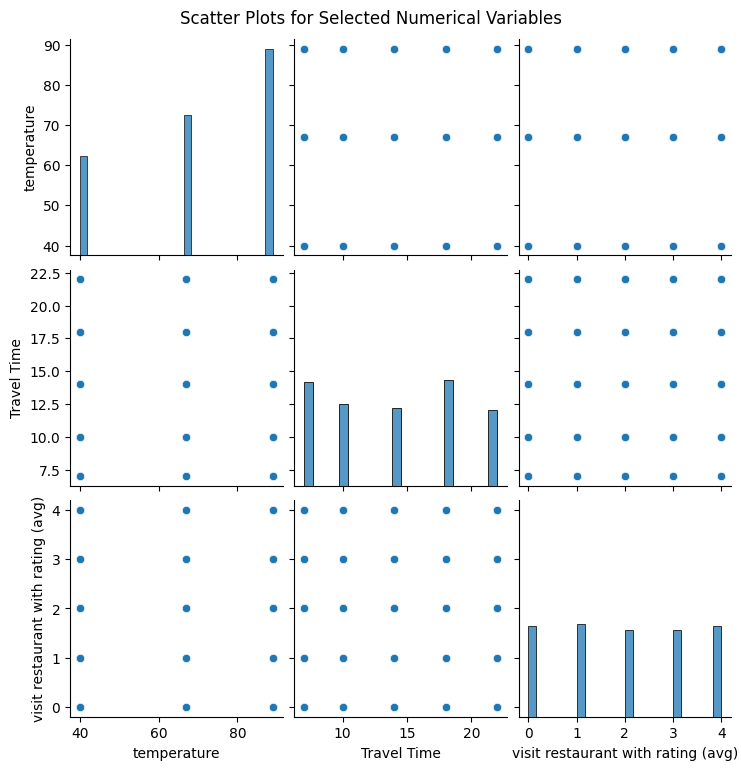

In [170]:
# Selecting a few numerical columns for scatter plot analysis
selected_columns_for_scatter = ['temperature', 'Travel Time', 'visit restaurant with rating (avg)']

# Plotting scatter plots for selected pairs of numerical variables
sns.pairplot(data=data, vars=selected_columns_for_scatter)
plt.suptitle('Scatter Plots for Selected Numerical Variables', y=1.02)
plt.show()


(Correlation Heatmap)

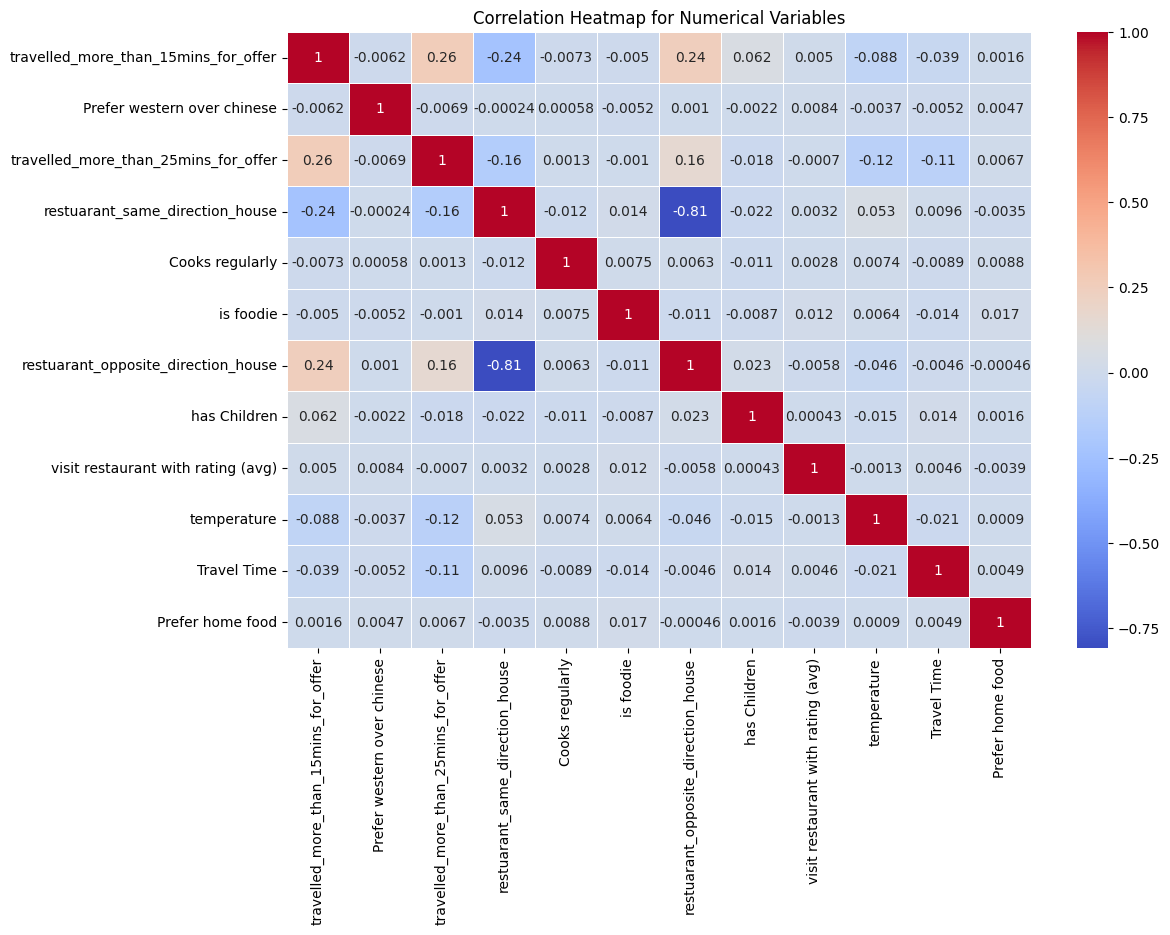

In [171]:
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns

# Calculating the correlation matrix for numerical variables
correlation_matrix = data[numerical_columns].corr()

# Plotting the heatmap for the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=.5)
plt.title('Correlation Heatmap for Numerical Variables')
plt.show()


- Multivariate Analysis

Analyzing More Than Two Variables 
(Scatter Plot for Multivariate Analysis)

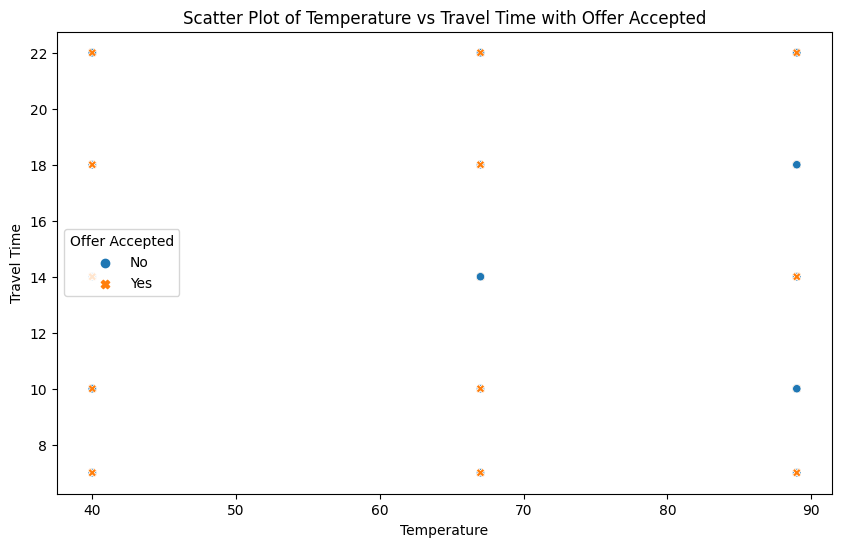

In [172]:
# Scatter plot for multivariate analysis
plt.figure(figsize=(10, 6))
sns.scatterplot(x='temperature', y='Travel Time', hue='Offer Accepted', style='Offer Accepted', data=data)
plt.title('Scatter Plot of Temperature vs Travel Time with Offer Accepted')
plt.xlabel('Temperature')
plt.ylabel('Travel Time')
plt.legend(title='Offer Accepted')
plt.show()


- Outlier Detection

(Box plot for Outlier Detection)

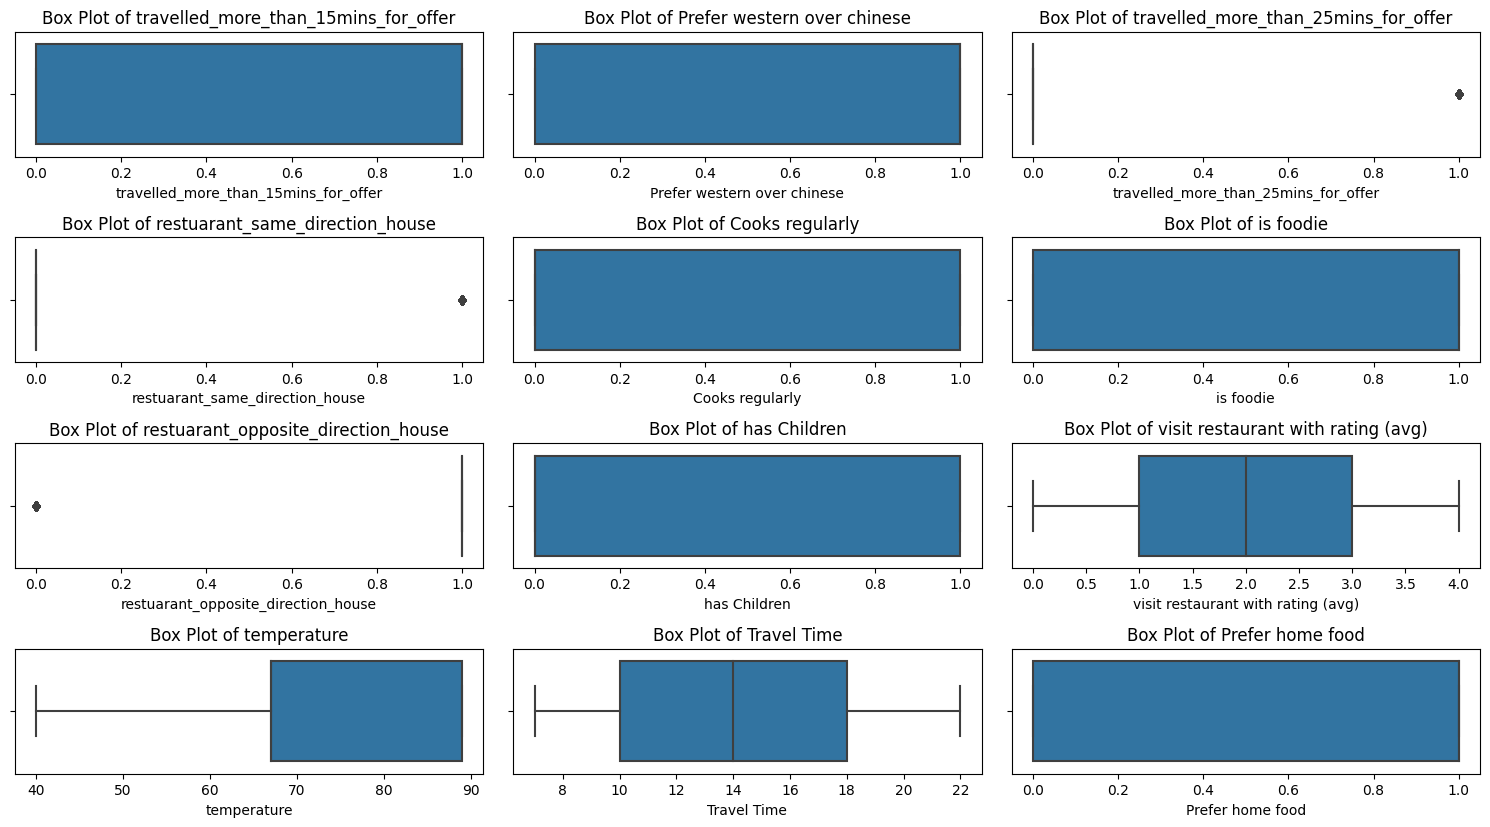

In [173]:
# Plotting box plots for numerical variables to identify outliers
plt.figure(figsize=(15, 10))
for idx, col in enumerate(numerical_columns, 1):
    plt.subplot(num_rows, 3, idx)
    sns.boxplot(x=data[col])
    plt.title(f'Box Plot of {col}')

plt.tight_layout()
plt.show()


**Cleaning & Feature Engineering**

In [174]:
unique_values_per_column = {col: df[col].unique() for col in df.columns}
allcols = df.columns
for col in allcols[:11]:
    print(f"{col} :==> {unique_values_per_column[col]}")
    print()

offer expiration :==> ['2days' '10hours']

income_range :==> ['₹100000 or More' '₹87500 - ₹99999' '₹37500 - ₹49999' 'Less than ₹12500'
 '₹50000 - ₹62499' '₹12500 - ₹24999' '₹75000 - ₹87499' '₹25000 - ₹37499'
 '₹62500 - ₹74999']

no_visited_Cold drinks :==> ['4~8' 'less1' 'never' '1~3' 'gt8' nan]

travelled_more_than_15mins_for_offer :==> [1 0]

Restaur_spend_less_than20 :==> ['less1' '4~8' '1~3' 'gt8' 'never' nan]

Marital Status :==> ['Married partner' 'Single' 'Divorced' 'Unmarried partner' 'Widowed']

restaurant type :==> ['4 star restaurant' 'Take-away restaurant' 'Cold drinks'
 'Restaurant with pub' '2 star restaurant']

age :==> ['36' '50plus' '26' '46' '21' 'below21' '41' '31']

Prefer western over chinese :==> [0 1]

travelled_more_than_25mins_for_offer :==> [0 1]

travelled_more_than_5mins_for_offer :==> [1]



In [175]:
for col in allcols[11:20]:
    print(f"{col} :==> {unique_values_per_column[col]}")
    print()

no_visited_bars :==> ['less1' 'never' '1~3' nan '4~8' 'gt8']

gender :==> ['Female' 'Male']

car :==> [nan 'Mazda5' 'Car that is too old to install Onstar :D' 'crossover'
 'Scooter and motorcycle' 'do not drive']

restuarant_same_direction_house :==> [0 1]

Cooks regularly :==> [1 0]

Customer type :==> ['Individual' 'With Family' 'With Kids' 'With Colleagues']

Qualification :==> ['Bachelors degree' 'Some college - no degree'
 'Graduate degree (Masters or Doctorate)' 'Associates degree'
 'High School Graduate' 'Some High School']

is foodie :==> [0 1]

no_Take-aways :==> ['1~3' 'gt8' '4~8' 'less1' nan 'never']



In [176]:
for col in allcols[20:21]:
    print(f"{col} :==> {unique_values_per_column[col]}")
    print()

Job/Job Industry :==> ['Unemployed' 'Arts Design Entertainment Sports & Media' 'Sales & Related'
 'Student' 'Business & Financial' 'Computer & Mathematical'
 'Office & Administrative Support' 'Management' 'Healthcare Support'
 'Life Physical Social Science' 'Installation Maintenance & Repair'
 'Legal' 'Community & Social Services' 'Education&Training&Library'
 'Construction & Extraction' 'Healthcare Practitioners & Technical'
 'Transportation & Material Moving' 'Retired' 'Architecture & Engineering'
 'Production Occupations' 'Farming Fishing & Forestry'
 'Protective Service' 'Personal Care & Service'
 'Food Preparation & Serving Related'
 'Building & Grounds Cleaning & Maintenance']



In [177]:
for col in allcols[21:]:
    print(f"{col} :==> {unique_values_per_column[col]}")
    print()

restuarant_opposite_direction_house :==> [0 1]

has Children :==> [0 1]

visit restaurant with rating (avg) :==> [4 3 0 1 2]

temperature :==> [67 89 40]

Restaur_spend_greater_than20 :==> ['less1' '1~3' 'never' 'gt8' nan '4~8']

Travel Time :==> [22 18  7 10 14]

Climate :==> ['Spring' 'Summer' 'Winter']

drop location :==> ['Location B' 'Location A' 'Location C']

Prefer home food :==> [0 1]

Offer Accepted :==> ['No' 'Yes']



**X-Y SPLIT**

In [178]:
def separate_columns(df):
    # Separate numerical and categorical columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df.select_dtypes(include=[object]).columns.tolist()

    # Further separate categorical columns into binary and multi-category columns
    binary_cols = [col for col in categorical_cols if df[col].nunique() == 2]
    multi_cols = [col for col in categorical_cols if df[col].nunique() > 2]

    return numeric_cols, categorical_cols, binary_cols, multi_cols


In [179]:
# Split the dataset into features and target variable
X = df.drop('Offer Accepted', axis=1)
y = df['Offer Accepted'].replace({'Yes': 1, 'No': 0})
numeric_cols, categorical_cols, binary_cols, multi_cols = separate_columns(X)
# Split the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


**PREPROCESSING**

In [180]:
# Custom transformer for manual encoding
# class CustomEncoder(BaseEstimator, TransformerMixin):
#     def __init__(self, mapping):
#         self.mapping = mapping

#     def fit(self, X, y=None):
#         return self  # No fitting necessary

#     def transform(self, X):
#         X_copy = X.copy()
#         for col, mapping in self.mapping.items():
#             X_copy[col] = X_copy[col].replace(mapping)
#         return X_copy
class CustomEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, mapping, unknown_value=-1):
        self.mapping = mapping
        self.unknown_value = unknown_value

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X_copy = X.copy()
        for col, mapping in self.mapping.items():
            # Replace known values based on the mapping
            X_copy[col] = X_copy[col].map(mapping)
            # Handle NaN and unknown values
            X_copy[col].fillna(self.unknown_value, inplace=True)
            X_copy[col] = X_copy[col].apply(lambda x: x if x in mapping.values() else self.unknown_value)
        return X_copy


# Custom transformer for value replacement
class CustomValueReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, replace_dict):
        self.replace_dict = replace_dict

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X_copy = X.copy()
        for col, mapping in self.replace_dict.items():
            X_copy[col] = X_copy[col].replace(mapping)
        return X_copy


- Numeric

In [181]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', StandardScaler())])

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

- Manual

In [182]:
# Columns to be manually encoded
manual_cols = [
    "offer expiration", "income_range", "no_visited_Cold drinks", "Restaur_spend_less_than20", "age",
    "no_visited_bars", "no_Take-aways", 
    "Restaur_spend_greater_than20"]
# Mapping Dicts
offer_expiration = {'10hours': 0, '2days': 1}
income_range = {
    'Less than ₹12500': 0, '₹12500 - ₹24999': 1, '₹25000 - ₹37499': 2, '₹37500 - ₹49999': 3, 
    '₹50000 - ₹62499': 4, '₹62500 - ₹74999': 5, '₹75000 - ₹87499': 6, '₹87500 - ₹99999': 7, 
    '₹100000 or More': 8}
no_visited_Cold_drinks = {'4~8': 2,'less1': 0,'1~3': 1,'gt8': 3}
Restaur_spend_less_than20 = {'4~8': 2,'less1': 0,'1~3': 1,'gt8': 3}
age = {'36': 4, '50plus': 7, '26': 2, '46': 6, '21': 1, 'below21': 0, '41': 5, '31': 3}
no_visited_bars = {'4~8': 2,'less1': 0,'1~3': 1,'gt8': 3}
no_Take_aways = {'4~8': 2,'less1': 0,'1~3': 1,'gt8': 3}
Restaur_spend_greater_than20 = {'4~8': 2,'less1': 0,'1~3': 1,'gt8': 3}

manual_mapping = {
    "offer expiration": offer_expiration,
    "income_range": income_range,
    "no_visited_Cold drinks": no_visited_Cold_drinks,
    "Restaur_spend_less_than20": Restaur_spend_less_than20,
    "age": age,
    "no_visited_bars": no_visited_bars,
    "no_Take-aways": no_Take_aways,
    "Restaur_spend_greater_than20": Restaur_spend_greater_than20,
}

manual_transformer = Pipeline(steps=[
    ('custom_encoder', CustomEncoder(mapping=manual_mapping))
])


- CatBinary & Categorical

In [183]:
# # Your existing feature columns
categorical_cols = ["Marital Status", "restaurant type", "gender", "car", "Customer type", 
                    "Qualification", "Job/Job Industry", "Climate", "drop location"]

# Define the preprocessing steps for all types of features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='missing')),
    # ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ('ordinalencoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])


- Clubbed Pipeline

In [184]:

# Group the preprocessing steps together
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_cols),
        ('manual', manual_transformer, manual_cols),
        ('cat', categorical_transformer, categorical_cols),
    ]
)


- Combined Preprocessor Pipeline followed by Replacer

In [185]:
# Define value replacement dictionary
replace_dict = {
    'no_visited_Cold drinks': {'never': 'less1'},
    'Restaur_spend_less_than20': {'never': 'less1'},
    'no_visited_bars': {'never': 'less1'},
    'no_Take-aways': {'never': 'less1'},
    'Restaur_spend_greater_than20': {'never': 'less1'}
}

# Create custom transformer
value_replacer = CustomValueReplacer(replace_dict=replace_dict)

# Add this step to your pipeline before other transformations
final_preprocessor_pipeline = Pipeline(steps=[
    ('value_replacer', value_replacer),
    ('preprocessor', preprocessor)
])


**MODELS PIPELINE**

In [186]:
# Define the models
models = [
    ('rf', RandomForestClassifier()), 
    ('dt', DecisionTreeClassifier()),
    ('gb', GradientBoostingClassifier()),
    ('xgb', XGBClassifier()),
]


In [187]:
# Define the pipelines
pipelines = []
for name, model in models:
    clf = Pipeline(steps=[('preprocessor', final_preprocessor_pipeline),
                          (name, model)])
    pipelines.append((name, clf))
print(pipelines[0][1][1])


RandomForestClassifier()


**INITIAL MODEL TRAINING & PERFORMANCE**

In [188]:
# Train the models and evaluate
model_performance = []
for name, pipeline in pipelines:
    print(f"Training : {name.upper()}.....")

    # Fit the pipeline on the training data
    model = pipeline.fit(X_train, y_train)

    # Predict on the test data
    y_pred = model.predict(X_test)

    # Compute metrics of the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    confusion = confusion_matrix(y_test, y_pred)

    print(f"Accuracy = {accuracy * 100:.2f} %")
    print(f"Precision = {precision * 100:.2f} %")
    print(f"Recall = {recall * 100:.2f} %")
    print(f"F1 Score = {f1 * 100:.2f} %")
    print()

    # Store the metrics and model parameters
    model_performance.append({
        'modelname': name, 
        'accuracy': accuracy, 
        'precision': precision, 
        'recall': recall, 
        'f1_score': f1, 
        'confusion_matrix': confusion,
        'parameters': model.get_params()
    })

# Create DataFrame from the model performance data
df_performance = pd.DataFrame(model_performance)

perf_dir = "./performance-reports"
# Create directories if they do not exist
os.makedirs(perf_dir, exist_ok=True)
# Save DataFrame to an Excel file
df_performance.to_excel("./performance-reports/initial-model-performance.xlsx")


Training : RF.....


Accuracy = 62.32 %
Precision = 62.13 %
Recall = 62.32 %
F1 Score = 60.91 %

Training : DT.....
Accuracy = 56.46 %
Precision = 56.41 %
Recall = 56.46 %
F1 Score = 56.43 %

Training : GB.....
Accuracy = 62.60 %
Precision = 62.53 %
Recall = 62.60 %
F1 Score = 61.02 %

Training : XGB.....
Accuracy = 61.35 %
Precision = 60.94 %
Recall = 61.35 %
F1 Score = 60.68 %



**DEFINE HYPERPARAMETERS & PLOTTING FUNCTIONS**

In [193]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.savefig(f'./plots/{model_name}_confusion_matrix.png')
    plt.show()
    plt.close()
def plot_roc_curve(y_true, y_prob, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.title('ROC Curve')
    plt.savefig(f'./plots/{model_name}_roc_curve.png')
    plt.show()
    plt.close()
def plot_precision_recall_curve(y_true, y_prob, model_name):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.savefig(f'./plots/{model_name}_precision_recall_curve.png')
    plt.show()
    plt.close()


In [190]:
# Hyperparameters specific to Gradient Boosting
gb_hyperparameters = {
    # 'gb__loss': ['log_loss', 'exponential'],
    'gb__n_estimators': [500], #[100, 250, 500, 750, 1000]
    'gb__learning_rate': [0.001, 0.01, 0.1],
    # 'gb__criterion': ['friedman_mse', 'squared_error'],
    # 'min_samples_split': [2,3,5],  #[2,3,5,7,10]
    'gb__max_depth': [10,15,20],    #[3,5,10,15,20]
    # 'gb__max_features': ['sqrt', 'log2']
}

**EXECUTE HPT AND PLOTTING PERFORMANCE METRICES**

In [191]:
# Initialize Gradient Boosting Pipeline (assuming you've already defined this)
gb_pipeline = [pipeline for name, pipeline in pipelines if name == 'gb'][0]

# Grid Search for Hyperparameter Tuning
grid_search_gb = GridSearchCV(gb_pipeline, gb_hyperparameters, cv=5, scoring='f1_weighted')

# Fit the model
grid_search_gb.fit(X_train, y_train)

# Prediction
y_pred_gb = grid_search_gb.predict(X_test)

# Compute Metrics
accuracy_gb = accuracy_score(y_test, y_pred_gb)
precision_gb = precision_score(y_test, y_pred_gb, average='weighted')
recall_gb = recall_score(y_test, y_pred_gb, average='weighted')
f1_gb = f1_score(y_test, y_pred_gb, average='weighted')

print(f"Accuracy for Gradient Boosting: {accuracy_gb:.2f}%")
print(f"Precision for Gradient Boosting: {precision_gb:.2f}%")
print(f"Recall for Gradient Boosting: {recall_gb:.2f}%")
print(f"F1 Score for Gradient Boosting: {f1_gb:.2f}%")


Accuracy for Gradient Boosting: 0.61%
Precision for Gradient Boosting: 0.60%
Recall for Gradient Boosting: 0.61%
F1 Score for Gradient Boosting: 0.60%


**SAVE BEST MODEL AND SAVE PLOTS**

Saved Gradient Boosting model to ./models/gb-model.pkl


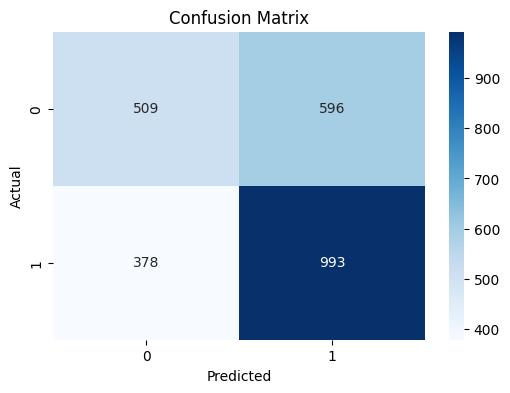

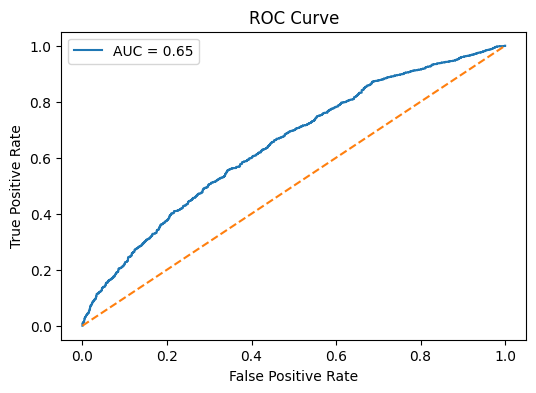

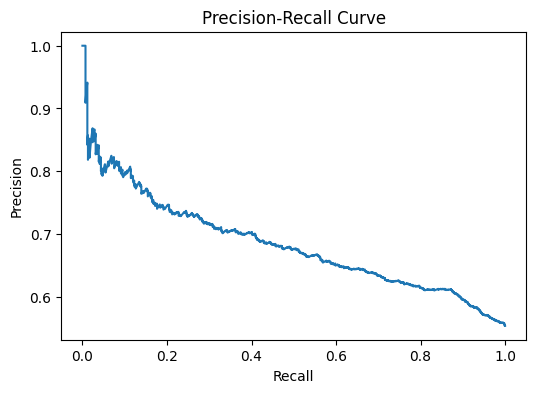

In [194]:
# Save the best model
gb_model_filename = "./models/gb-model.pkl"
os.makedirs('./models', exist_ok=True)
joblib.dump(grid_search_gb.best_estimator_, gb_model_filename)
print(f"Saved Gradient Boosting model to {gb_model_filename}")

# Plotting
os.makedirs('./plots', exist_ok=True)
y_prob_gb = grid_search_gb.predict_proba(X_test)[:, 1]
plot_confusion_matrix(y_test, y_pred_gb, 'Gradient Boosting')
plot_roc_curve(y_test, y_prob_gb, 'Gradient Boosting')
plot_precision_recall_curve(y_test, y_prob_gb, 'Gradient Boosting')